# Parameter Estimation using basico


**Description** <br>
Parameter estimation (parameter fitting) is a process of finding the best set of parameters for a model to fit the experimental data. Basico enables both local and global parameter estimation algorithms.

**Setup** <br>
To accomplish parameter estimation task, the following components are required:
* model *(ODE model in SBML format)*
* experimental data *(time series in a table format)*
* parameters to be estimated *(can be both kinetic parameters and initial concentrations)*
* algorithms for the parameter estimation task (see here: https://basico.readthedocs.io/en/latest/API/basico.html#basico.task_parameterestimation.run_parameter_estimation)
* available range (constraints) for the parameters

**Parameter estimation workflow** <br>
1. Load model and remove previous experiments (`basico.remove_experiments()`)
2. Add experimental data (`basico.add_experiment(name, data)`)
3. Add reaction parameters to be estimated together with their upper and lower bounds <br>
Create a list of dictionaries where each dictionary contains the name of the parameter, its lower and upper bounds. <br>
E.g.
```
fit_items = [
            {'name': '(R1).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R2).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R3).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R4).k1', 'lower': 0.001, 'upper': 2},
        ]	
```
4. Set parameters to be estimated (`basico.set_fit_parameters(fit_items)`) <br>
4.1 (optional) Constrains for the concentrations. Solutions with concentrations outside a certain range are rejected. <br>
5. Run parameter estimation (`basico.run_parameter_estimation(method='Levenberg - Marquardt', update_model=True)`). If the  `update_model` parameter is set to `True`, the model will be updated with the estimated parameters, thus it is possible to restart the estimation process from the same point in the parameter space, but with different algorithm.
6. Evaluate the results (parameter values and the objective function value) and run model with estimated parameters. <br>
`basico.get_fit_statistic(include_parameters=True)`


**Visualisation and ouput** <br>
The progress of the parameter estimation can be tracked visually by observing the objective value (y -axis) over number of iterations (x-axis) of the estimation algorithm, ideally, as a curve. Also output of the estimated values in a table where *before* and *after* values can be compared would be beneficial.

**Testing** <br>
Use the example below ('brusselator') to see if the parameter estimation is running correctly. Ideally, the estimation should end with exactly the original parameters of this example. The estimation process can be time and resource-consuming. For testing it is important to use local methods, such as , e.g. `Levenberg - Marquardt` or set **the seed** for global methods, since global methods use stochastic algorithms to set initial starting point for the estimation.

**Note** <br>
Since parameter estimation task is usually an interative process, the user should be able to stop the estimation process at any time, evaluate the results, and resume it with another algorithm or with the same algorithm.


## Example

In [3]:
import os
import pandas as pd
import basico
import matplotlib.pyplot as plt
import numpy as np

#### Generate noisy data for a mock parameter estimation task

In [4]:
basico.load_example('brusselator')
# remove previous experiments to avoid contamination
basico.remove_experiments()
# create noisy data from the model, that we will take for a parameter estimation
basico.add_parameter('obs_x', type='assignment', expression='[X] + UNIFORM(0,1) - 0.5')
basico.add_parameter('obs_y', type='assignment', expression='[Y] + UNIFORM(0,1) - 0.5');

In [5]:
result = basico.run_time_course(start_time=0, use_number=True)

In [6]:
result.head()

,X,Y,Values[obs_x],Values[obs_y]
Time,,,,
0.0,2.999996,2.999996,3.041699,3.028853
0.5,3.408155,0.817484,3.440078,0.534975
1.0,1.896454,1.276790,2.106532,0.858355
1.5,0.876253,1.872929,1.236137,1.529346
2.0,0.345934,2.368188,0.792790,2.645165


In [7]:
# obtain "experimental data"
data = result.drop(columns=['X', 'Y'])
data.rename(columns = {'Values[obs_x]':'[X]', 'Values[obs_y]':'[Y]'}, inplace=True)
data = data.reset_index()

#### Original values


In [8]:
basico.get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).k1,1.0,R1,local,
(R2).k1,1.0,R2,local,
(R3).k1,1.0,R3,local,
(R4).k1,1.0,R4,local,


#### Setting up "worng" parameter values

In [9]:
# change parameters so we have something to do
basico.set_reaction_parameters(['(R1).k1', '(R2).k1', '(R3).k1', '(R4).k1'], value=0.5)
basico.remove_parameter('obs_x')
basico.remove_parameter('obs_y')
#basico.run_time_course(start_time=0).plot();

#### Modified values

In [10]:
basico.get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).k1,0.5,R1,local,
(R2).k1,0.5,R2,local,
(R3).k1,0.5,R3,local,
(R4).k1,0.5,R4,local,


#### Experimental data

In [11]:
# here's how data looks like
data.head()

,Time,[X],[Y]
0,0.0,3.041699,3.028853
1,0.5,3.440078,0.534975
2,1.0,2.106532,0.858355
3,1.5,1.236137,1.529346
4,2.0,0.792790,2.645165


In [12]:
# add experimental data to the estimation task
basico.add_experiment('exp1', data)

'c:\\Users\\Wehling\\code\\feat-estimation\\AIAgents4Pharma\\docs\\notebooks\\talk2biomodels\\exp1.txt'

In [13]:
#check if the mapping was correct
basico.get_experiment_mapping('exp1')

,type,mapping,cn,column_name
column,,,,
0,time,,,Time
1,dependent,[X],"CN=Root,Model=The Brusselator,Vector=Compartme...",[X]
2,dependent,[Y],"CN=Root,Model=The Brusselator,Vector=Compartme...",[Y]


#### Add which reaction parameters to estimate

In [14]:
# adding reaction parameters to the experiment
fit_items = [
            {'name': '(R1).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R2).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R3).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R4).k1', 'lower': 0.001, 'upper': 2},
        ]


In [15]:
basico.set_fit_parameters(fit_items)
basico.get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
(R1).k1,0.001,2,0.5,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R2).k1,0.001,2,0.5,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R3).k1,0.001,2,0.5,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R4).k1,0.001,2,0.5,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."


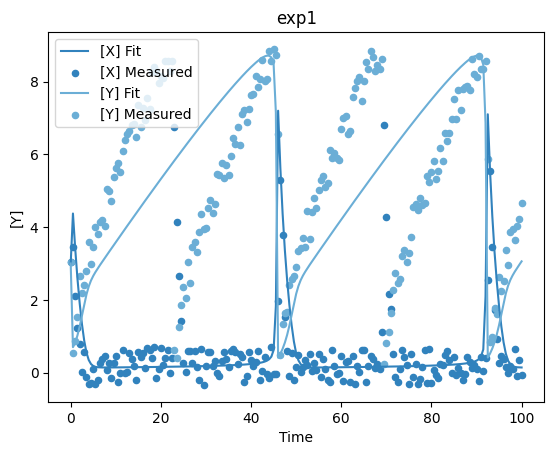

In [16]:
basico.plot_per_experiment();

#### Setting constraints for the concentrations


In [17]:
#setting constraints for the fitting task
# solutions with concentrations outside a certain range are rejected
basico.set_fit_constraints([
    {'name': 'Y', 'lower': 0, 'upper': 10}
])

### Running parameter estimation task

In [18]:
basico.run_parameter_estimation(method='Levenberg - Marquardt', update_model=True)

,lower,upper,sol,affected
name,,,,
(R1).k1,0.001,2,0.744007,[]
(R2).k1,0.001,2,0.457557,[]
(R3).k1,0.001,2,0.434593,[]
(R4).k1,0.001,2,0.948480,[]


In [19]:
basico.run_parameter_estimation(method='Evolution Strategy (SRES)', update_model=True)

,lower,upper,sol,affected
name,,,,
(R1).k1,0.001,2,1.078017,[]
(R2).k1,0.001,2,0.544177,[]
(R3).k1,0.001,2,0.688952,[]
(R4).k1,0.001,2,0.896619,[]


#### Review fit statistics


In [20]:
basico.get_fit_statistic(include_parameters=False)

{'obj': 21.74449507822359,
 'rms': 0.23257425432896822,
 'sd': 0.23374004736946635,
 'f_evals': 23908,
 'failed_evals_exception': 0,
 'failed_evals_nan': 0,
 'constraint_evals': 23901,
 'failed_constraint_evals': 871,
 'cpu_time': 13.59375,
 'data_points': 402,
 'valid_data_points': 402,
 'evals_per_sec': 0.0005685858290112096}

### Loading data from a file


In [21]:
# load data from file
exp_file = "exp1.txt"
exp_data = pd.read_csv(exp_file, sep="\t") # Ensure correct separator
